In [141]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add ,Bidirectional
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
BASE_DIR="/kaggle/input/flickr8k"

In [8]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [9]:
features = {}
directory = os.path.join('/kaggle/input/flickr8k', 'Images')

for img_name in tqdm(os.listdir(directory)):

    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
 
    image = preprocess_input(image)
  
    feature = model.predict(image, verbose=0)
   
    image_id = img_name.split('.')[0]
   
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
pickle.dump(features,open("features_flickr.pkl",'wb'))

In [10]:
features=pickle.load(open("/kaggle/input/features/features_flickr.pkl",'rb'))

In [130]:
len(features)

8091

In [29]:
for x in list(features.keys())[:5]:
    print(x)

3226254560_2f8ac147ea
214543992_ce6c0d9f9b
2366643786_9c9a830db8
3368819708_0bfa0808f8
2190227737_6e0bde2623


In [123]:
features['3226254560_2f8ac147ea'][0]

array([0.       , 1.6273944, 0.       , ..., 0.       , 1.5637894,
       0.       ], dtype=float32)

In [33]:
#Reading caption
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [35]:
captions_doc[:20]

'1000268201_693b08cb0'

In [36]:
captions_doc.split('\n')[0].split(',')[0] , captions_doc.split('\n')[0].split(',')[1]

('1000268201_693b08cb0e.jpg',
 'A child in a pink dress is climbing up a set of stairs in an entry way .')

In [49]:
captions_doc.split('\n')[:3]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .']

In [37]:

    
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [38]:
len(mapping)

8091

In [32]:
print({k: mapping[k] for k in list(mapping)[:5]})

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

In [39]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [43]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [50]:
clean(mapping)

In [51]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [62]:
all_caption=[]
for cap in mapping:
    for cc in mapping[cap]:
        all_caption.append(cc)

In [69]:
all_caption[0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [64]:
len(all_caption)

40455

In [66]:
#tokenize
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_caption)

In [68]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8485


In [106]:
#Max len caption
max_length=max(len (x.split()) for x in all_caption)
print(max_length)

35


In [107]:
image_index=list(mapping.keys())
split=int(len(image_index)*0.90)
train=image_index[:split]
test=image_index[split:]

In [ ]:
seq=tokenizer.texts_to_sequences([all_caption[0]])[0]
for i in range(1, len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]             
    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
print(in_seq)
print(out_seq)

In [124]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0


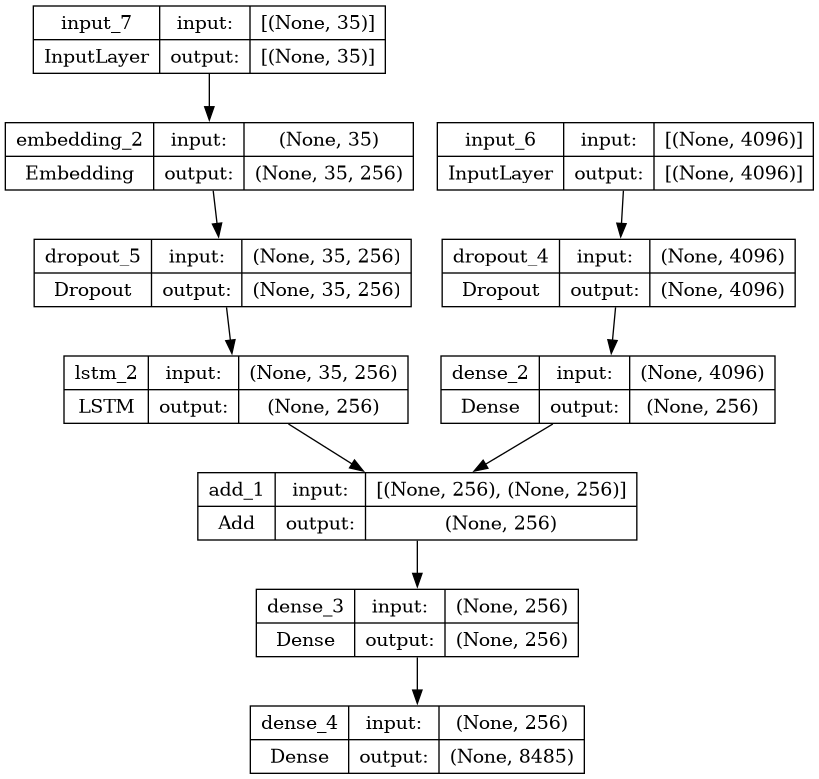

In [129]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [131]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 44s 194ms/step - loss: 1.9673


In [133]:
model.save('/kaggle/working/captioning.h5')

In [135]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [137]:
pickle.dump(tokenizer,open("Tokenizer.pkl",'wb'))

In [138]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [139]:
vgg_model = VGG16() 

vgg_model = Model(inputs=vgg_model.inputs,             
                  outputs=vgg_model.layers[-2].output)

In [7]:
def generate_caption(image_path):
    
    image_show = Image.open(image_path)
    
    
    image = load_img(image_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image, verbose=0)
    # predict from the trained model
    pre=predict_caption(model, feature, tokenizer, max_length)
    pre=' '.join(pre.split()[1:-1])
    plt.title(pre)
    print(pre)
    plt.imshow(image_show)

In [8]:
generate_caption("/kaggle/input/flickr8k/Images/102455176_5f8ead62d5.jpg")

NameError: name 'Image' is not defined